In [8]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Sort sessions by patient and date
#df = df.sort_values(by=['Subject_ID', 'Date'])
# Load the restructured session data
df = pd.read_excel('../../data_set/hd_sessions/cleaned_session_data.xlsx')

# 2. Create the target: Next session's dry weight - current dry weight
df['Next Dry weight (kg)'] = df.groupby('Subject_ID')['Dry weight (kg)'].shift(-1)
df['Dry weight adjustment (kg)'] = df['Next Dry weight (kg)'] - df['Dry weight (kg)']

# 3. Drop rows where the target is NaN (i.e., last session for a patient)
df = df.dropna(subset=['Dry weight adjustment (kg)']).reset_index(drop=True)

# print first few rows to verify
print(df.head())


    Subject_ID Session_No       Date  AP (mmHg)  AUF (ml)  BFR (ml/min)  \
0  RHD_THP_001  Session 1 2024-02-01     -143.0    1000.0         200.0   
1  RHD_THP_001  Session 2 2024-05-01     -164.0    3300.0         180.0   
2  RHD_THP_001  Session 3 2024-09-01     -166.0    3000.0         200.0   
3  RHD_THP_001  Session 4 2024-12-01     -142.0    3300.0         250.0   
4  RHD_THP_001  Session 5 2024-01-16     -126.0    2000.0         250.0   

   Dry weight (kg)  HD duration (h)  PUF (ml)  Post HD weight (kg)  \
0             68.5                4    1600.0                 68.5   
1             68.5                4    3300.0                 68.4   
2             68.5                4    3000.0                 68.7   
3             68.5                4    3300.0                 68.7   
4             68.5                4    2000.0                 68.5   

   Pre HD weight (kg)  TMP (mmHg)  VP (mmHg)  Weight gain (kg)  SYS (mmHg)  \
0                70.1          43      126.0      

c:\Users\nandu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


MAE: 0.150
RMSE: 0.784
R²: 0.997


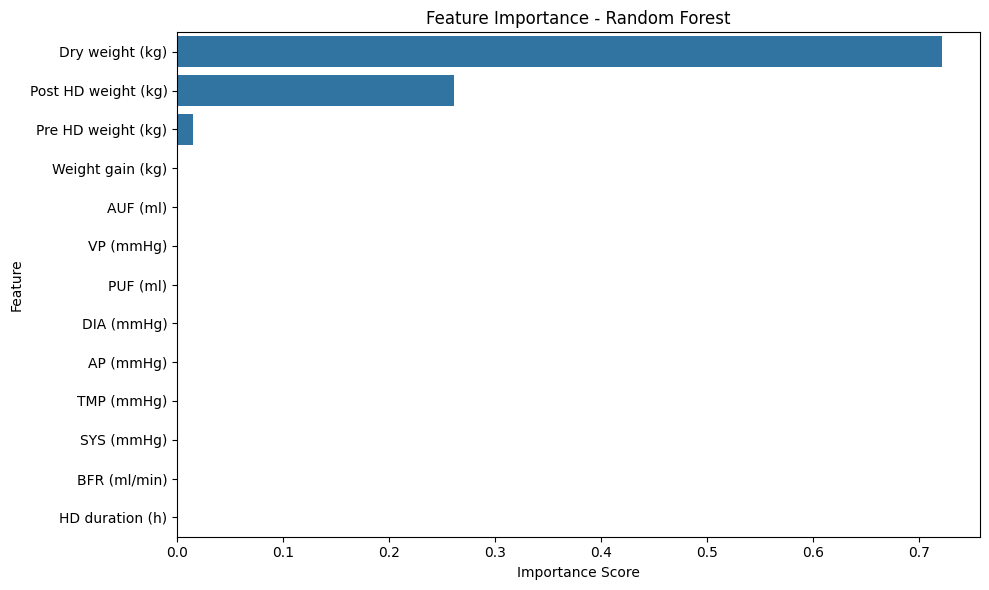

In [9]:
# 4. Define feature columns (based on your dataset)
features = [
    'AP (mmHg)', 'AUF (ml)', 'BFR (ml/min)', 'Dry weight (kg)', 'HD duration (h)',
    'PUF (ml)', 'Post HD weight (kg)', 'Pre HD weight (kg)', 'TMP (mmHg)', 
    'VP (mmHg)', 'Weight gain (kg)', 'SYS (mmHg)', 'DIA (mmHg)'
]

# 5. Prepare features (X) and target (y)
X = df[features]
y = df['Next Dry weight (kg)']

# 6. Fill missing values if any (optional: can use more advanced imputation)
X = X.fillna(X.median())

# 7. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 8. Train the Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# 9. Predictions and evaluation
y_pred = rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")

# 10. Feature importance plot
importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title('Feature Importance - Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# y_test: true values
# y_pred: predicted values from your model

def evaluate_regression(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    
    n = len(y_test)        # number of observations
    p = 1 if len(y_pred.shape) == 1 else y_pred.shape[1]  # number of predictors
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

    print("📊 Model Performance Metrics:")
    print(f"➡️  Mean Absolute Error (MAE):       {mae:.3f}")
    print(f"➡️  Mean Squared Error (MSE):        {mse:.3f}")
    print(f"➡️  Root Mean Squared Error (RMSE):  {rmse:.3f}")
    print(f"➡️  R² Score:                        {r2:.3f}")
    print(f"➡️  Adjusted R² Score:               {adj_r2:.3f}")


# y_pred = model.predict(X_test)
evaluate_regression(y_test, y_pred)


📊 Model Performance Metrics:
➡️  Mean Absolute Error (MAE):       0.150
➡️  Mean Squared Error (MSE):        0.615
➡️  Root Mean Squared Error (RMSE):  0.784
➡️  R² Score:                        0.997
➡️  Adjusted R² Score:               0.997


c:\Users\nandu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


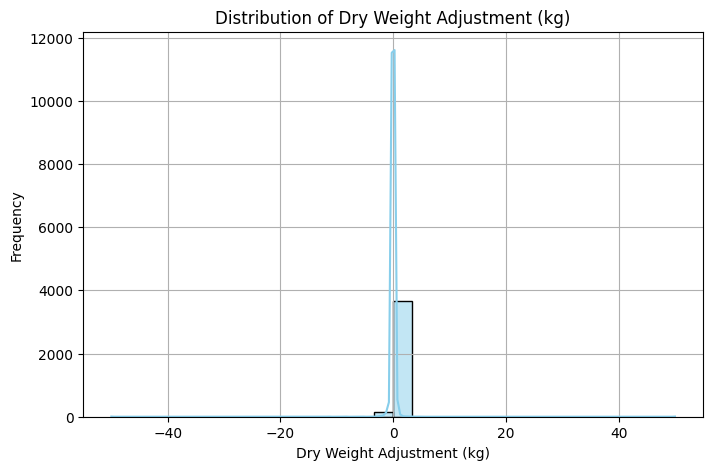

Sessions with no dry weight change: 3497 / 3811 (91.8%)


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(df['Dry weight adjustment (kg)'], kde=True, bins=30, color='skyblue')
plt.title('Distribution of Dry Weight Adjustment (kg)')
plt.xlabel('Dry Weight Adjustment (kg)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

zero_adjustments = (df['Dry weight adjustment (kg)'] == 0).sum()
total = len(df)
print(f"Sessions with no dry weight change: {zero_adjustments} / {total} ({(zero_adjustments/total)*100:.1f}%)")

